In [ ]:
import pandas as pd
from google.colab import drive

# Load the dataset
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/ML Project/continuous_factory_process.csv'
df = pd.read_csv(file_path)



Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# select features and targets
X = df.iloc[:, 1:41]  # Features from start to Combiner stage

# Calculate error based on interleaved columns
num_measurements = len(df.columns[42:71]) // 2  # Number of measurements
actual_cols = df.columns[42:72:2]  # Actual columns (every other column starting from 42)
setpoint_cols = df.columns[43:72:2]  # Setpoint columns (every other column starting from 43)


#new error dataframe
error_df = df[actual_cols].values - df[setpoint_cols].values
y = pd.DataFrame(error_df, columns=[col.replace(".C.Actual", ".Error") for col in actual_cols])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=122)



In [ ]:
print(y)

       Stage1.Output.Measurement0.U.Actual  \
0                                    -1.03   
1                                    -1.41   
2                                    -1.41   
3                                    -1.41   
4                                    -1.46   
...                                    ...   
14083                                -1.14   
14084                                -1.14   
14085                                -1.14   
14086                                -1.17   
14087                                -1.17   

       Stage1.Output.Measurement1.U.Actual  \
0                                   -22.74   
1                                   -22.74   
2                                   -22.74   
3                                   -22.74   
4                                   -22.74   
...                                    ...   
14083                               -22.74   
14084                               -22.74   
14085                            

In [ ]:
# Feature scaling (important for linear regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(y_test, y_pred)  # Calculate R-squared


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error: 5.646065850946727
Root Mean Squared Error (RMSE): 2.37614516621917
R-squared (R2): 0.3773550800594362


In [ ]:
## random forest
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor

X = df.iloc[:, 1:41]  # Features from start to Combiner stage

# Calculate error based on interleaved columns
num_measurements = len(df.columns[42:71]) // 2  # Number of measurements
actual_cols = df.columns[42:72:2]  # Actual columns (every other column starting from 42)
setpoint_cols = df.columns[43:72:2]  # Setpoint columns (every other column starting from 43)


#new error dataframe
error_df = df[actual_cols].values - df[setpoint_cols].values
y = pd.DataFrame(error_df, columns=[col.replace(".C.Actual", ".Error") for col in actual_cols])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=122)

# Feature scaling (usually not required for Random Forest but good practice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=122)  # Create the model
model.fit(X_train, y_train)  # Train the model



RandomForestRegressor(random_state=122)

In [ ]:

# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# hyperparameter tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None],  # Feature selection per split
    'bootstrap': [True, False],  # Whether to sample data with replacement
}


random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=122), param_grid,
    n_iter=20,  # Only test 20 random combinations instead of all 81
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
print(random_search.best_params_)




{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [ ]:
#optimized random forest model

model = RandomForestRegressor(n_estimators=200,
                              min_samples_split=10,
                              min_samples_leaf=2,
                              max_features='sqrt',
                              max_depth=None,
                              bootstrap=False,
                              random_state=122)  # Add random_state for reproducibility

model.fit(X_train, y_train)



RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=200, random_state=122)

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(y_test, y_pred)  # Calculate R-squared

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 2.9182226182610047
Root Mean Squared Error (RMSE): 1.7082806029048638
R-squared (R2): 0.6337142688688482


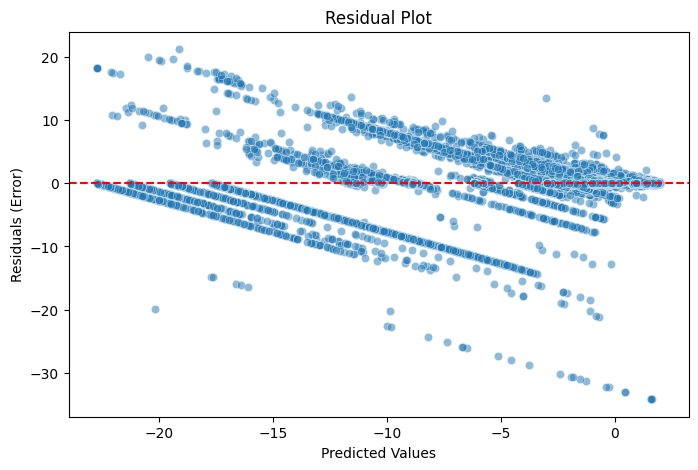

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
residuals = y_test - y_pred

# Convert y_pred and residuals to 1-dimensional arrays if they are not
y_pred = y_pred.ravel()  # Flatten y_pred if it's multi-dimensional
residuals = residuals.values.ravel()  # Flatten residuals if it's multi-dimensional


plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Reference line at 0 error
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

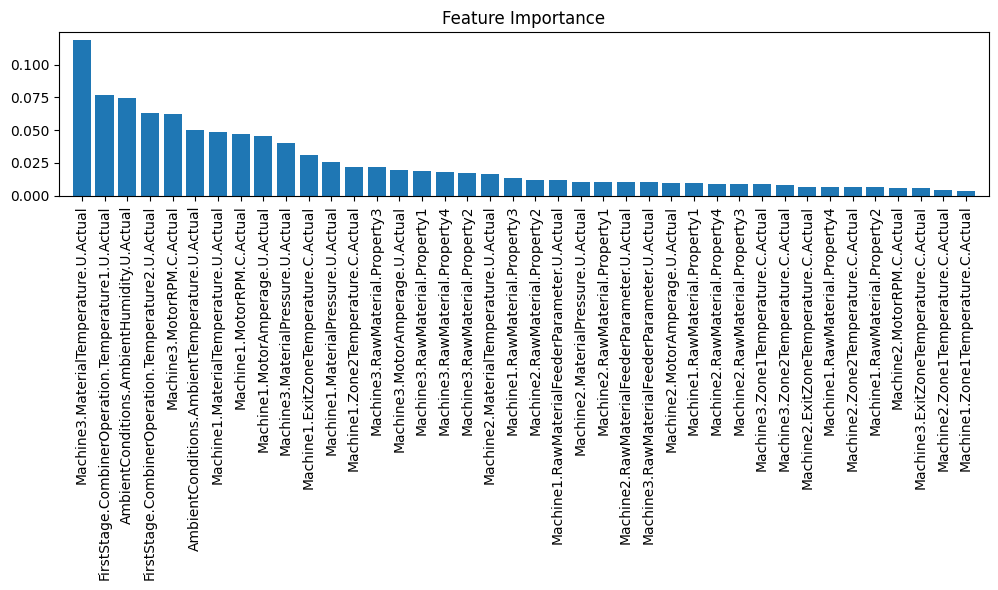

In [ ]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
feature_names = X.columns  # Assuming X is your feature DataFrame

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

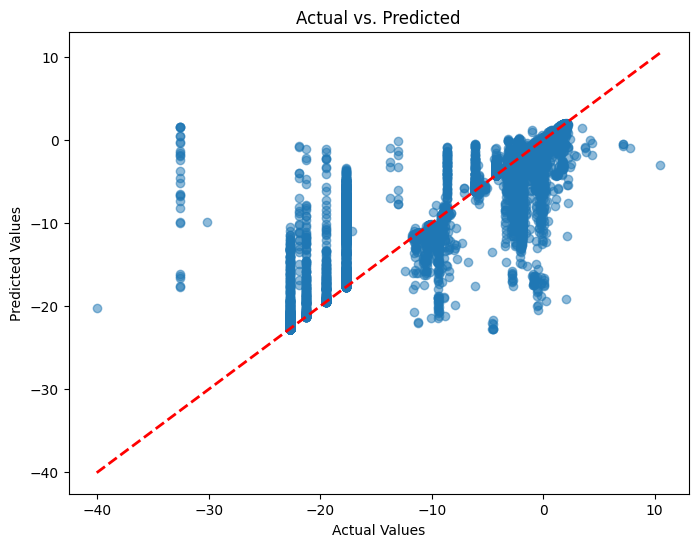

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test.values.ravel(), y_pred, alpha=0.5)  # Use .values.ravel() on y_test
plt.plot([y_test.min().min(), y_test.max().max()], [y_test.min().min(), y_test.max().max()], 'r--', lw=2)  # Perfect prediction line, adjusted for DataFrame
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.show()

In [ ]:
# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # Input layer with 64 units and ReLU activation
    layers.Dense(32, activation='relu'), # Hidden layer with 32 units and ReLU activation
    layers.Dense(y_train.shape[1]) # Output layer with linear activation (for regression)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1316.6321 - mae: 18.4587 - val_loss: 17.9177 - val_mae: 2.8763
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 16.0076 - mae: 2.6595 - val_loss: 13.1321 - val_mae: 2.2823
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.2007 - mae: 2.2053 - val_loss: 11.4621 - val_mae: 2.0482
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11.2025 - mae: 2.0557 - val_loss: 11.3091 - val_mae: 2.0234
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.7999 - mae: 2.0293 - val_loss: 10.7775 - val_mae: 2.0248
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.5815 - mae: 1.9862 - val_loss: 10.0964 - val_mae: 1.8583
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.2604 - mae: 1.9165 - val_loss: 12.3523 - val_mae: 2.2173
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10.2237 - mae: 1.9250 - val_loss: 9.9173 - val_mae: 1.8769
Epoch 9/100
247/247 ━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
loss, mae = model.evaluate(X_test, y_test, verbose=0)
y_test = model
print("Mean Absolute Error:", mae)
rmse = np.sqrt(mae)


NameError: name 'model' is not defined

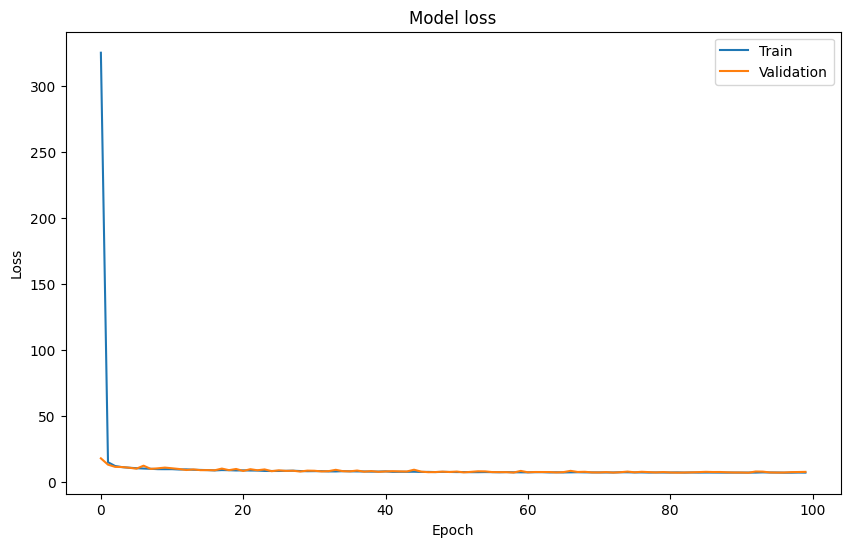

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


ValueError: x and y must be the same size

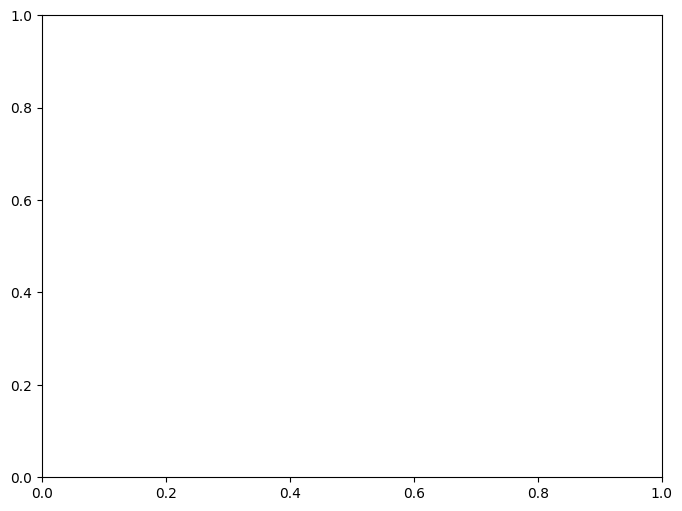

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred.flatten(), y=residuals.flatten(), alpha=0.5)  # Use .flatten() to convert to 1D
plt.axhline(y=0, color='r', linestyle='--')  # Reference line at 0 error
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()

TypeError: unsupported operand type(s) for -: 'Sequential' and 'float'